In [423]:
import itertools
import os.path as op
import glob
import nibabel as nib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import sem
import scipy.signal as sp
import os
import pickle
import warnings
import tqdm

warnings.filterwarnings('ignore')

In [424]:
def load_retinotopy(subj_prf_directory, load_hemis, ret_params):
    ret = {p:{'lh':[], 'rh':[]} for p in ret_params}

    for hemi, param in itertools.product(load_hemis, ret_params):
        rfile = glob.glob(op.join(subj_prf_directory, '%s*%s.mgz') % (hemi, param))
        r = nib.load(rfile[0]).get_fdata().squeeze()
        ret[param][hemi].append(r)
    
    for param in ret_params:
        ret[param]['b'] = [np.concatenate(b) for b in zip(ret[param]['lh'], ret[param]['rh'])]
        
    return ret


def ret_hemi_DF(wlsubj, ret, hemi = 'b'):
    df = {}
    for param in ret.keys():
        df[param] = ret[param][hemi][0]
    
    df = pd.DataFrame(df)
    df = df.assign(wlsubj=wlsubj)
    
    return df
        
    

In [126]:
ret_params = ['x', 'y', 'eccen', 'angle', 'sigma', 'vexpl', 'ROIs_V1-3']
prf_dir = "//Users/rob/mnt/winawer/Projects/Retinotopy_NYU_3T/derivatives/prfanalyze-vista/sub-wlsubj%03d/ses-nyu3t01" 
load_hemis = ['lh', 'rh']

wlsubjects = os.listdir('//Users/rob/mnt/winawer/Projects/Retinotopy_NYU_3T/derivatives/prfanalyze-vista/')
wlsubjects = [w.strip('sub-wlsubj') for w in wlsubjects if 'wlsubj' in w]
wlsubjects.sort()
wlsubjects.pop()
wlsubjects = [int(w) for w in wlsubjects]

In [177]:
if not op.exists('../retinotopy/NYU_ret.tsv'):
    print('Concatenating retinotopy data...')
    columns = [p for p in ret_params]
    columns.append('wlsubj')

    retinotopy = pd.DataFrame(columns = columns)
    failed_subs = []

    for wlsubj in tqdm.tqdm(wlsubjects):
        try:
            sub_prf = load_retinotopy(prf_dir % wlsubj, load_hemis, ret_params)
            ret = ret_hemi_DF(wlsubj, sub_prf)
            retinotopy = retinotopy.append(ret)
        except:
            failed_subs.append(wlsubj)

    retinotopy.to_csv('../retinotopy/NYU_ret.tsv', sep = '\t')
    
else:
    print('Data found. Loading...')
    retinotopy = pd.read_csv('../retinotopy/NYU_ret.tsv', sep = '\t')
    retinotopy = retinotopy.rename(columns = {'Unnamed: 0':'voxel_num', 'ROIs_V1-3':'roi'})

Data found. Loading...


In [207]:
retinotopy[retinotopy.roi.isin([1, 2])]

,voxel_num,x,y,eccen,angle,sigma,vexpl,roi,wlsubj
0,0,1.647007,2.294927,2.824769,-0.948307,0.764268,0.819769,1.0,1
1,1,1.624933,2.281579,2.801073,-0.951932,0.749242,0.828746,1.0,1
2,2,0.471587,2.061776,2.115021,-1.345936,1.047159,0.506775,1.0,1
3,3,0.740176,2.139602,2.264013,-1.237742,0.782955,0.599854,1.0,1
4,4,1.770180,2.255161,2.866930,-0.905302,0.639680,0.826398,1.0,1
...,...,...,...,...,...,...,...,...,...
10058161,302970,-2.480000,-9.450069,9.770067,1.827441,1.850000,0.155115,2.0,133
10058211,303020,-1.490622,-6.675346,6.839751,1.790494,0.690967,0.187512,2.0,133
10059893,304702,-0.992000,-8.590972,8.648055,1.685757,1.231250,0.187841,2.0,133
10059894,304703,-0.432274,-8.176734,8.188152,1.623613,1.499796,0.163752,2.0,133


In [416]:
def filter_ret(voxels, rois = [], sd_ecc=0, sd_ang=0):
    
    if rois:
        voxels = voxels[voxels.roi.isin(rois)]
    if sd_ecc:
        voxels = voxels[np.abs(sd_ecc - voxels.eccen) <= voxels.sigma]
    if sd_ang:
        voxels = voxels[np.abs(sd_ang - np.degrees(voxels.angle)) <= voxels.sigma**2]
        
    return voxels

v1 = filter_ret(retinotopy, rois = [1], sd_ecc = 7)
v2 = filter_ret(retinotopy, rois = [2], sd_ecc = 7)
v3 = filter_ret(retinotopy, rois = [3], sd_ecc = 7)
v = filter_ret(retinotopy, rois = [1, 2, 3])



<AxesSubplot:xlabel='eccen', ylabel='angle'>

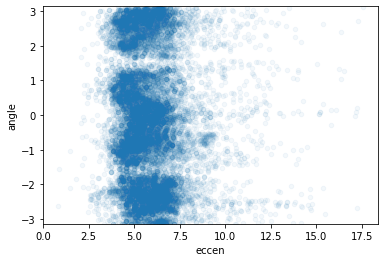

In [417]:
v3.plot.scatter('eccen', 'angle', alpha = 0.05, ylim = [-np.pi, np.pi])


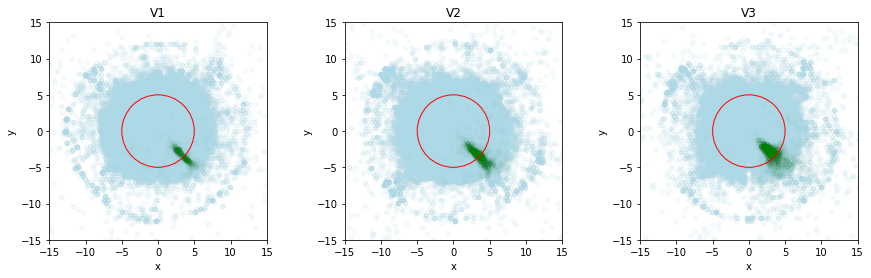

In [421]:
stim_ecc = 7
stim_ang = 45

fig, axs = plt.subplots(1, 3, figsize = (15, 4))
v1 = filter_ret(retinotopy, rois = [1], sd_ecc = stim_ecc, sd_ang = stim_ang)
v2 = filter_ret(retinotopy, rois = [2], sd_ecc = stim_ecc, sd_ang = stim_ang)
v3 = filter_ret(retinotopy, rois = [3], sd_ecc = stim_ecc, sd_ang = stim_ang)
v = filter_ret(retinotopy, rois = [1, 2, 3])

v[v.roi.isin([1])].plot.scatter('x', 'y', ax = axs[0], title = 'V1', xlim = [-15, 15], ylim = [-15, 15], alpha = 0.1, c = 'lightblue')
v[v.roi.isin([2])].plot.scatter('x', 'y', ax = axs[1], title = 'V2', xlim = [-15, 15], ylim = [-15, 15], alpha = 0.1, c = 'lightblue')
v[v.roi.isin([3])].plot.scatter('x', 'y', ax = axs[2], title = 'V3', xlim = [-15, 15], ylim = [-15, 15], alpha = 0.1, c = 'lightblue')

v1.plot.scatter('x', 'y', ax = axs[0], title = 'V1', xlim = [-15, 15], ylim = [-15, 15], c = 'green', alpha = 0.01)

v2.plot.scatter('x', 'y', ax = axs[1], title = 'V2', xlim = [-15, 15], ylim = [-15, 15], c = 'green', alpha = 0.01)

v3.plot.scatter('x', 'y', ax = axs[2], title = 'V3', xlim = [-15, 15], ylim = [-15, 15], c = 'green', alpha = 0.01)

ecc_circle1 = plt.Circle((0, 0), stim_ecc, color='r', fill=False)
ecc_circle2 = plt.Circle((0, 0), stim_ecc, color='r', fill=False)
ecc_circle3 = plt.Circle((0, 0), stim_ecc, color='r', fill=False)

axs[0].add_patch(ecc_circle1)
axs[1].add_patch(ecc_circle2)
axs[2].add_patch(ecc_circle3)
axs[0].set_aspect('equal')
axs[1].set_aspect('equal')
axs[2].set_aspect('equal')

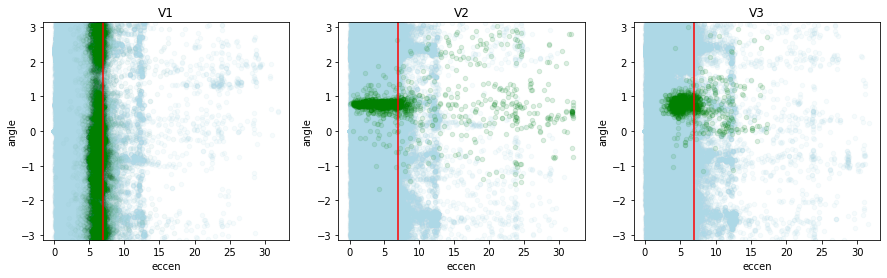

In [419]:
fig, axs = plt.subplots(1, 3, figsize = (15, 4))
v[v.roi.isin([1])].plot.scatter('eccen', 'angle', ax = axs[0], title = 'V1', ylim = [-np.pi, np.pi], alpha = 0.1, c = 'lightblue')
v[v.roi.isin([2])].plot.scatter('eccen', 'angle', ax = axs[1], title = 'V2', ylim = [-np.pi, np.pi], alpha = 0.1, c = 'lightblue')
v[v.roi.isin([3])].plot.scatter('eccen', 'angle', ax = axs[2], title = 'V3', ylim = [-np.pi, np.pi], alpha = 0.1, c = 'lightblue')

v1.plot.scatter('eccen', 'angle', ax = axs[0], title = 'V1', c = 'green', alpha = 0.01, ylim = [-np.pi, np.pi])

v2.plot.scatter('eccen', 'angle', ax = axs[1], title = 'V2', c = 'green', alpha = 0.1, ylim = [-np.pi, np.pi])

v3.plot.scatter('eccen', 'angle', ax = axs[2], title = 'V3', c = 'green', alpha = 0.1, ylim = [-np.pi, np.pi])

axs[0].axvline(x = stim_ecc, color = 'red')
axs[1].axvline(x = stim_ecc, color = 'red')
axs[2].axvline(x = stim_ecc, color = 'red')

-0.0554503599802653


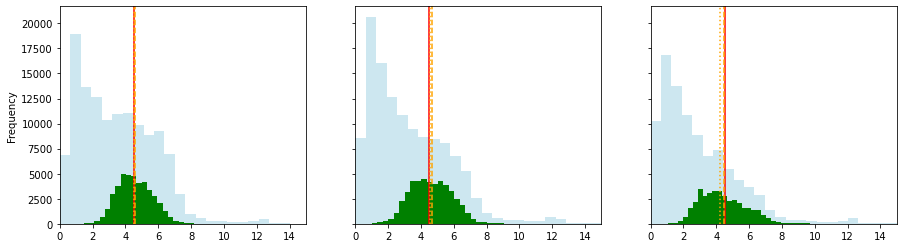

In [370]:
fig, axs = plt.subplots(1, 3, figsize = (15, 4), sharey = True)

v[v.roi.isin([1])].eccen.plot.hist(bins = 50, ax = axs[0], color = 'lightblue', alpha = 0.6, xlim = [0, 15])
v[v.roi.isin([2])].eccen.plot.hist(bins = 50, ax = axs[1], color = 'lightblue', alpha = 0.6, xlim = [0, 15])
v[v.roi.isin([3])].eccen.plot.hist(bins = 50, ax = axs[2], color = 'lightblue', alpha = 0.6, xlim = [0, 15])

v1.eccen.plot.hist(bins = 50, ax = axs[0], color = 'green')
v2.eccen.plot.hist(bins = 50, ax = axs[1], color = 'green')
v3.eccen.plot.hist(bins = 50, ax = axs[2], color = 'green')


axs[0].axvline(x = stim_ecc, c = 'r')
axs[0].axvline(x = v1.eccen.mean(), c = 'orange', linestyle = '--')
axs[0].axvline(x = v1.eccen.median(), c = 'orange', linestyle = ':')

axs[1].axvline(x = stim_ecc, c = 'r')
axs[1].axvline(x = v2.eccen.mean(), c = 'orange', linestyle = '--')
axs[1].axvline(x = v2.eccen.median(), c = 'orange', linestyle = ':')

axs[2].axvline(x = stim_ecc, c = 'r')
axs[2].axvline(x = v3.eccen.mean(), c = 'orange', linestyle = '--')
axs[2].axvline(x = v3.eccen.median(), c = 'orange', linestyle = ':')

dist = ((v1.eccen.median() - stim_ecc) + (v2.eccen.median() - stim_ecc) + (v3.eccen.median() - stim_ecc)) / 3
print(dist)

In [371]:
(v3.eccen - stim_ecc).mean()

-0.056350939156764916

-0.1675102710723877

In [360]:
dists_mean = []
dists_median = []
eccentricities = np.linspace(0, 15, 100)
for stim_ecc in eccentricities:

    v_sub = filter_ret(retinotopy, rois = [1, 2, 3], stim_ecc = stim_ecc, sd=True)

    dist_median = (np.abs(v_sub[v_sub.roi.isin([1])].eccen.median() - stim_ecc) + \
            np.abs(v_sub[v_sub.roi.isin([2])].eccen.median() - stim_ecc) + \
            np.abs(v_sub[v_sub.roi.isin([3])].eccen.median() - stim_ecc)) / 3
    dist_mean = (np.abs(v_sub[v_sub.roi.isin([1])].eccen.mean() - stim_ecc) + \
            np.abs(v_sub[v_sub.roi.isin([2])].eccen.mean() - stim_ecc) + \
            np.abs(v_sub[v_sub.roi.isin([3])].eccen.mean() - stim_ecc)) / 3
    
    dists_median.append(dist_median)
    dists_mean.append(dist_mean)
    
dists_mean = np.asarray(dists_mean)
dists_median = np.asarray(dists_median)
# optim_ecc = eccentricities[np.argmin(dists)]

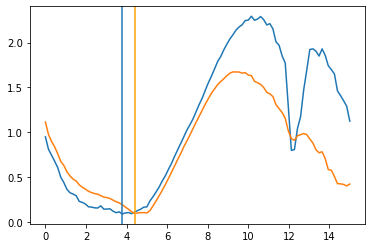

In [381]:
plt.plot(eccentricities, dists_median)
plt.plot(eccentricities, dists_mean)
plt.axvline(eccentricities[dists_median.argmin()])
plt.axvline(eccentricities[dists_mean.argmin()], color = 'orange')

In [425]:
v

,voxel_num,x,y,eccen,angle,sigma,vexpl,roi,wlsubj
0,0,1.647007,2.294927,2.824769,-0.948307,0.764268,0.819769,1.0,1
1,1,1.624933,2.281579,2.801073,-0.951932,0.749242,0.828746,1.0,1
2,2,0.471587,2.061776,2.115021,-1.345936,1.047159,0.506775,1.0,1
3,3,0.740176,2.139602,2.264013,-1.237742,0.782955,0.599854,1.0,1
4,4,1.770180,2.255161,2.866930,-0.905302,0.639680,0.826398,1.0,1
...,...,...,...,...,...,...,...,...,...
10063416,308225,-3.472000,-2.577291,4.324028,2.503033,2.881250,0.793216,3.0,133
10064967,309776,-4.925252,-5.456698,7.350760,2.305050,4.443774,0.798097,3.0,133
10064968,309777,-4.226189,-5.448328,6.895285,2.230535,3.594315,0.712844,3.0,133
10064969,309778,-4.334797,-5.372379,6.903110,2.249711,3.390535,0.683323,3.0,133


In [430]:
voxels = filter_ret(retinotopy, rois = [1, 2, 3], sd_ecc = 7)
sub = voxels[voxels.wlsubj == 114]

sub

,voxel_num,x,y,eccen,angle,sigma,vexpl,roi,wlsubj
6197668,19,-1.736000,5.584132,5.847754,-1.872205,3.087500,0.052226,1.0,114
6197669,20,-1.488000,5.154583,5.365060,-1.851831,2.468750,0.067319,1.0,114
6197998,349,3.063889,3.532088,4.675796,-0.856262,2.336809,0.687031,2.0,114
6197999,350,2.360244,4.059278,4.695581,-1.044132,2.634341,0.549020,2.0,114
6198002,353,1.194662,5.247120,5.381402,-1.346933,2.628645,0.532331,1.0,114
...,...,...,...,...,...,...,...,...,...
6499971,302322,-4.133711,-6.906307,8.048891,2.110143,3.713808,0.621092,3.0,114
6500007,302358,-6.930429,-3.157531,7.615829,2.714088,3.901688,0.776588,3.0,114
6500019,302370,-6.047513,-3.594958,7.035350,2.605262,3.783951,0.740842,3.0,114
6500020,302371,-6.483308,-3.276455,7.264189,2.673660,3.845597,0.746672,3.0,114


In [446]:
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    
    return(rho, phi)


def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = -(rho * np.sin(phi))
    
    return(x, y)


def rotated_xy(angle, rotate_by):
    angle 
    
    return rot_x, rot_y
    



In [447]:
x,y = pol2cart(sub.eccen, sub.angle)

In [450]:
x

6197668    -1.736000
6197669    -1.488000
6197998     3.063889
6197999     2.360244
6198002     1.194662
             ...    
6499971    -4.133711
6500007    -6.930429
6500019    -6.047513
6500020    -6.483308
6708409    11.408000
Length: 3916, dtype: float64

In [452]:
sub

6197668   -1.872205
6197669   -1.851831
6197998   -0.856262
6197999   -1.044132
6198002   -1.346933
             ...   
6499971    2.110143
6500007    2.714088
6500019    2.605262
6500020    2.673660
6708409   -0.542221
Name: angle, Length: 3916, dtype: float64

In [ ]:
voxels_by_stimangle = prevoxels.filter(['x', 'y', 'eccen', 'angle', 'sigma', 'vexpl',
       'surf_label'])

voxel_dfs = {}

    
for c in conds:
    idx = np.where(new_cbt == c)[0]
    if len(idx) == 1: print(c)
    v = prevoxels.iloc[:, idx]
    v = v.mean(axis = 1)

    voxels_by_stimangle.insert(int(c), str(c), v)
    
    
for t in np.unique(tasks):
    voxel_dfs[t] = prevoxels.filter(['x', 'y', 'eccen', 'angle', 'sigma', 'vexpl',
       'surf_label'])
    voxel_dfs[t]['task'] = t
    idx = np.where(tasks == t)[0]
    print(idx)
    voxel_dfs[t] = voxel_dfs[t].merge(voxels_by_stimangle.iloc[:, idx], left_index = True, right_index = True)
    voxel_dfs[t] = voxel_dfs[t].melt(id_vars=['x', 'y', 'eccen', 'angle', 'sigma', 'vexpl', 'surf_label', 'task'], 
        var_name="condition", 
        value_name="beta")
    
    stim_angle = angles[voxel_dfs[t].condition.values.astype(int)]
    
    theta = np.asarray([convert_angle(a) for a in np.degrees(voxel_dfs[t].angle)])
    
    target_dist = fix_deg(theta - stim_angle)
    
    voxel_dfs[t].insert(9, 'pref_angle', theta)
    voxel_dfs[t].insert(10, 'stim_angle', stim_angle)
    voxel_dfs[t].insert(11, 'target_dist', target_dist)
    
    # Bin these distances
    dist_bins = np.arange(-180, 220, 20) - 10
    bins = pd.cut(voxel_dfs[t]['target_dist'], bins=dist_bins)
    bins = bins.apply(center_bin).astype(float)
    bins[bins == -180.0] = 180.0
    voxel_dfs[t].insert(12, 'ang_dist_bin', bins)
    
    voxel_dfs[t] = voxel_dfs[t].rename(columns = {'surf_label': 'roi'})
    voxel_dfs[t].insert(0, 'subj', 'wlsubj%03d' % wlsubj)

interstellar = pd.concat(voxel_dfs)
interstellar_norm = norm_group(interstellar, precision = True)

groups = interstellar_norm.groupby('task')
fig, axes = plt.subplots(1, interstellar_norm.task.nunique(), figsize=(18,5), sharey = True)

for i, (gname, gdata) in enumerate(groups):
    sns.scatterplot(x='ang_dist_bin', y='beta_adj', data=gdata, ax=axes[i]).set_title(gname.title())
    
